## 회귀(Regression)
- 회귀 분석: 데이터 값이 평균과 같은 일정한 값으로 돌아가려는 경향을 이용한 통계학 기법
- 회귀 계수: 독립변수(피처)에 영향을 미치는 가중치(ai가 설계해주는 것)
- 분류와 회귀의 차이는 분류는 예측값이 카테고리(이산형), 회귀는 연속된 숫자형이다.
- MSE를 최소로하는 모델을 설계하는 것이 목표 (비용함수 최저(cost function))
- 선을 잘 그어서 학습을 시켜야한다.

## LinearRegression을 이용한 보스턴 주택 가격 예측

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

boston = load_boston()

bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)
bostonDF['PRICE'] = boston.target # 주택 가격 예측이 target
print('Boston 데이터 세트 크기: ', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기:  (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


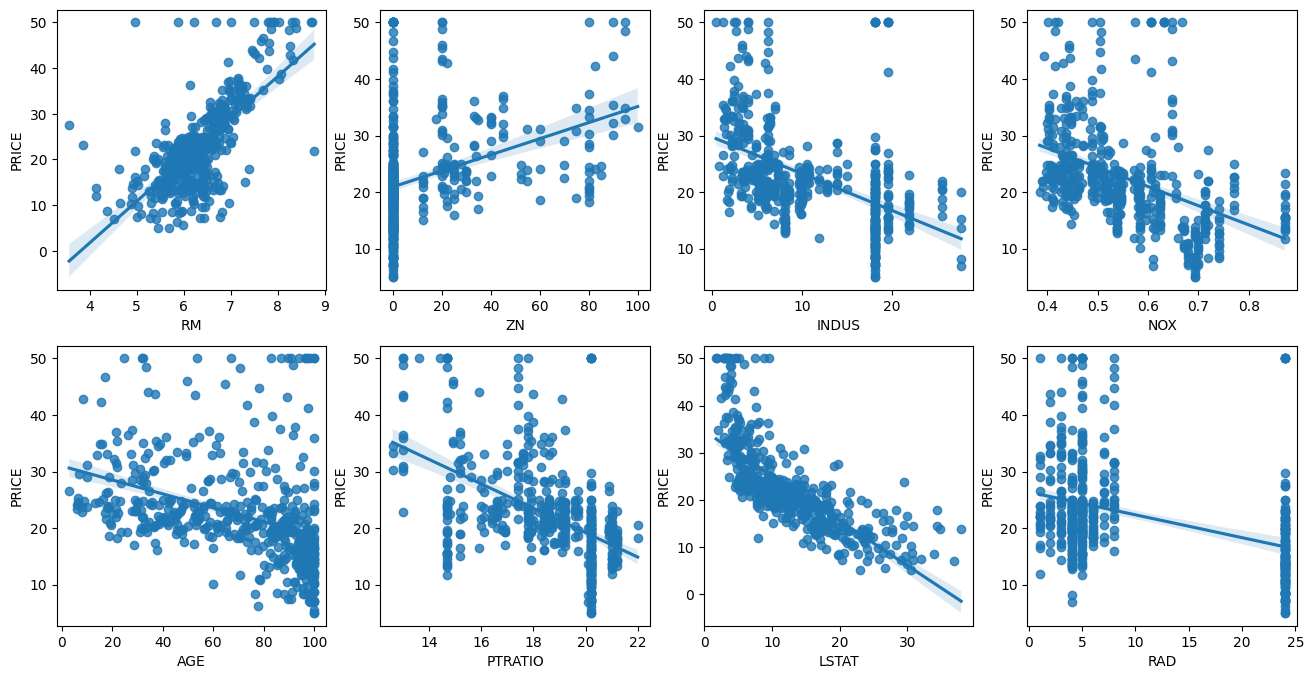

In [2]:
# 각 칼럼이 회귀 결과에 미치는 영향 시각화
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE'] # 가격 예측이 target
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE: {0:.3f}, RMSE: {1:.3f}'.format(mse, rmse))
print('Variance score: {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE: 17.297, RMSE: 4.159
Variance score: 0.757


In [4]:
print('절편 값: ', lr.intercept_)
print('회귀 계수 값: ', np.round(lr.coef_, 1))

절편 값:  40.99559517216451
회귀 계수 값:  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [5]:
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [6]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE'] # 가격 예측이 target
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
# 회귀는 mse값이 낮을수록 좋은 회귀모델이기 때문에 metrics의 평가기준에 mse를 부합시키기 위해 scoring 설정

rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print('5 folds의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores:  [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE: 5.829


## 규제 선형 회귀
- 비용 함수에 `alpha`값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식
- 학습 데이터 잔차 오류 최소화 + 회귀 계수 크기 제어
- `w`값이 너무 이상하게 커지는 것을 방지하기 위함
    - `Ridge`: `alpha`를 통해 기울기가 덜 민감하게 반응하게 끔 만든다(=결과가 확 바뀌는 경우를 방지함)
    - `Lasso`: 아예 없애버리자, 피처가 많을 때, 시각화할 때 중요한 피처만 남겨서 봄. 불필요한 회귀계수를 급격하게 감소시켜 0으로 만들고 제거.
    - `ElasticNet`: 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우에 이들 중에서 중요한 피처만 남겨두고 나머지 회귀계수는 0으로.

### 릿지 (Ridge)
- 과적합된 다중 선형 회귀 모델은 단 하나의 특이값에도 회귀선의 기울기가 크게 변할 수 있다. 
- 릿지 회귀는 어떤 값을 통해 이 기울기가 덜 민감하게 반응하게끔 만드는데, 이 값을 람다(lambda, λ)라고 한다.(=alpha)
- **선형 회귀에 큰 회귀 계수 값의 예측 영향도를 감소시키기 위해 회귀 계수 값을 더 작게 만드는 L2규제를 추가한 회귀 모델**

In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기: ',bostonDF.shape)

y_target = bostonDF['PRICE'] # 가격 예측이 target
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores: ', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

Boston 데이터 세트 크기:  (506, 14)
5 folds의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE: 5.518


In [8]:
alphas = [0, 0.1, 1, 10, 100]
for alpha in alphas:
    ridge = Ridge(alpha=alpha)

    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)

    print('alpha = {0}일 때 5 folds의 평균 RMSE: {1:.3f}'.format(alpha, avg_rmse))

alpha = 0일 때 5 folds의 평균 RMSE: 5.829
alpha = 0.1일 때 5 folds의 평균 RMSE: 5.788
alpha = 1일 때 5 folds의 평균 RMSE: 5.653
alpha = 10일 때 5 folds의 평균 RMSE: 5.518
alpha = 100일 때 5 folds의 평균 RMSE: 5.330


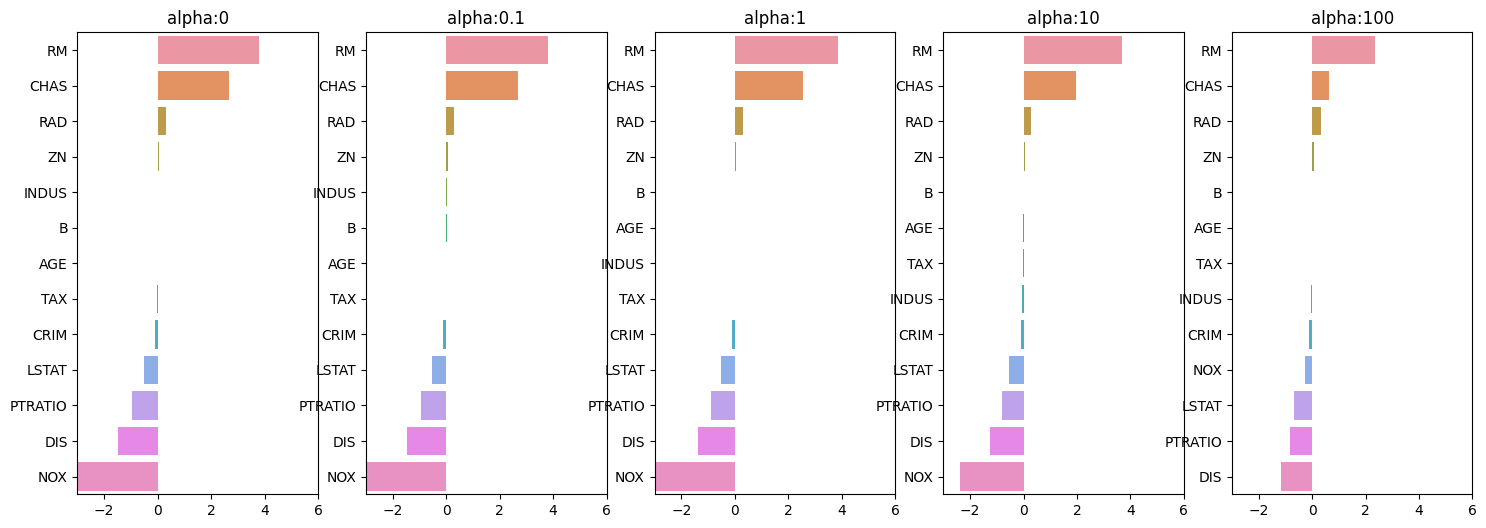

In [9]:
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=5)
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)

    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha:' + str(alpha)
    coeff_df[colname] = coeff

    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

plt.show()

In [10]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

# alpha가 커질수록 각 피처들의 w가 작아지는 것을 확인할 수 있다.

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


### 라쏘 (Lasso)
- 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거함(L1 규제)

In [11]:
from sklearn.linear_model import Lasso, ElasticNet

def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('######', model_name, '######')
    for param in params:
        if model_name == 'Ridge':
            model = Ridge(alpha=param)
        elif model_name == 'Lasso':
            model = Lasso(alpha=param)
        elif model_name == 'ElasticNet':
            model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {0} 일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))

        model.fit(X_data_n, y_target_n)
        if return_coeff:
            coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
            colname = 'alpha:'+str(param)
            coeff_df[colname] = coeff
    
    return coeff_df

In [20]:
lasso_alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

###### Lasso ######
alpha 0.01 일 때 5 폴드 세트의 평균 RMSE: 5.740
alpha 0.02 일 때 5 폴드 세트의 평균 RMSE: 5.679
alpha 0.03 일 때 5 폴드 세트의 평균 RMSE: 5.644
alpha 0.04 일 때 5 폴드 세트의 평균 RMSE: 5.637
alpha 0.05 일 때 5 폴드 세트의 평균 RMSE: 5.628
alpha 0.06 일 때 5 폴드 세트의 평균 RMSE: 5.618


In [21]:
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.01,alpha:0.02,alpha:0.03,alpha:0.04,alpha:0.05,alpha:0.06
RM,3.814186,3.820592,3.825939,3.831277,3.836618,3.818558
CHAS,2.504190,2.316725,2.131692,1.946662,1.761631,1.594050
RAD,0.298526,0.292030,0.285037,0.278040,0.271034,0.269686
ZN,0.046860,0.047382,0.047863,0.048345,0.048826,0.049008
B,0.009485,0.009664,0.009840,0.010017,0.010193,0.010248
INDUS,0.006474,-0.004214,-0.016592,-0.028973,-0.041355,-0.043953
AGE,-0.001818,-0.004329,-0.006839,-0.009348,-0.011858,-0.012262
TAX,-0.012627,-0.013011,-0.013351,-0.013689,-0.014028,-0.014197
CRIM,-0.106228,-0.104380,-0.102566,-0.100752,-0.098935,-0.098294
LSTAT,-0.530481,-0.536422,-0.542254,-0.548088,-0.553925,-0.557652


### 엘라스틱넷 (ElasticNet)
- 필요한 피처만 남겨두기

In [14]:
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=y_target)

###### ElasticNet ######
alpha 0.07 일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5 일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1 일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3 일 때 5 폴드 세트의 평균 RMSE: 6.068


In [15]:
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000
